# GAM (Generalized Additive Model) Logistic Regression for Pitcher Injury Prediction (2018-2025 → 2026 Forecast)

This notebook implements three variants of GAM Logistic Regression to forecast pitcher injury probability for the 2026 season using data from 2018-2025.

## Model Variants:

**Model 1: Baseline (Unmodifiable Attributes Only)**
- Philosophy: "Can we predict injury from things the pitcher/org can't change?"
- Features: Age (+ age²), Height, Weight, BMI, Birth country, Previous injury history

**Model 2: Modifiable Attributes Only (Workload + Biomechanics)**
- Philosophy: "Can we predict injury from things the org can control?"
- Features: Workload metrics, Pitch mix, Velocity, Mechanics (release point consistency), Biomechanics

**Model 3: Full Model (Unmodifiable + Modifiable)**
- Philosophy: "Use everything we know"
- Features: All features from Model 1 + Model 2


In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM, s, f
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, accuracy_score, precision_score, 
                            recall_score, f1_score, log_loss)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## Data Loading and Exploration


In [44]:
# Load the data
df = pd.read_csv('mlb_injuries.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['had_arm_injury_this_year'].value_counts())
print(f"\nInjury rate: {df['had_arm_injury_this_year'].mean():.3f}")
print(f"\nYears available: {sorted(df['game_year'].unique())}")
print(f"\nMissing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0])


Dataset shape: (6300, 60)

Target variable distribution:
had_arm_injury_this_year
0.0    4994
1.0    1306
Name: count, dtype: int64

Injury rate: 0.207

Years available: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

Missing values per column:
Series([], dtype: int64)


In [45]:
# Prepare data for modeling
# Filter data from 2018-2025 (for forecasting 2026)
df_model = df[df['game_year'] <= 2025].copy()

# Create age squared feature
df_model['age_squared'] = df_model['age'] ** 2

# Target variable
target = 'had_arm_injury_this_year'
y = df_model[target].copy()

print(f"Modeling dataset shape: {df_model.shape}")
print(f"Injury rate: {df_model[target].mean():.3f}")

# Create a single train/test split for fair comparison across all models
# Use a simple feature column for splitting, then extract indices
X_dummy = df_model[['age']].copy()
X_dummy_train, X_dummy_test, y_train_temp, y_test_temp = train_test_split(
    X_dummy, y, test_size=0.2, random_state=42, stratify=y
)

# Extract indices from the split
train_idx = X_dummy_train.index
test_idx = X_dummy_test.index

# Define y_train and y_test for use across all models
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print(f"\nTrain set size: {len(train_idx)}")
print(f"Test set size: {len(test_idx)}")
print(f"Train injury rate: {y_train.mean():.3f}")
print(f"Test injury rate: {y_test.mean():.3f}")


Modeling dataset shape: (6300, 61)
Injury rate: 0.207

Train set size: 5040
Test set size: 1260
Train injury rate: 0.207
Test injury rate: 0.207


---

## Model 1: Baseline GAM (Unmodifiable Attributes Only)

**Features:**
- Age + Age²
- Height
- Weight  
- BMI
- Birth country (categorical)
- Previous arm injury history


In [46]:
# Model 1: Unmodifiable attributes only - GAM
model1_features = ['age', 'age_squared', 'height', 'weight', 'bmi', 
                   'birth_country', 'prev_arm_inj_history']

# Prepare features
X1 = df_model[model1_features].copy()

# Separate continuous and categorical features for GAM
continuous_features = ['age', 'age_squared', 'height', 'weight', 'bmi', 'prev_arm_inj_history']
categorical_features = ['birth_country']

# Use the same train/test split for all models
X1_train = X1.loc[train_idx].copy()
X1_test = X1.loc[test_idx].copy()
# y_train and y_test already defined from Cell 4

# Encode categorical variable for GAM (needs integer encoding)
birth_country_map = {country: idx for idx, country in enumerate(X1_train['birth_country'].unique())}
X1_train['birth_country_encoded'] = X1_train['birth_country'].map(birth_country_map)
X1_test['birth_country_encoded'] = X1_test['birth_country'].map(birth_country_map).fillna(0)

# Prepare feature matrix for GAM: continuous features first, then categorical
X1_train_gam = X1_train[continuous_features + ['birth_country_encoded']].values
X1_test_gam = X1_test[continuous_features + ['birth_country_encoded']].values

# Build GAM formula: smooth terms for continuous, factor for categorical
n_continuous = len(continuous_features)
n_categorical = 1  # birth_country

# Create GAM terms: smooth splines for continuous variables, factor for categorical
# Build terms using + operator
gam_term = s(0, n_splines=10)  # First continuous feature
for i in range(1, n_continuous):
    gam_term += s(i, n_splines=10)  # Add other continuous features
gam_term += f(n_continuous)  # Add factor term for categorical

# Fit GAM
model1 = LogisticGAM(gam_term)
model1.fit(X1_train_gam, y_train.values)

# Predictions
y1_pred_proba = model1.predict_proba(X1_test_gam)
y1_pred = (y1_pred_proba > 0.5).astype(int)

# Metrics
print("=" * 60)
print("MODEL 1: Baseline GAM (Unmodifiable Attributes Only)")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test, y1_pred):.4f}")
print(f"Precision: {precision_score(y_test, y1_pred):.4f}")
print(f"Recall: {recall_score(y_test, y1_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y1_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y1_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y1_pred_proba):.4f}")

# Cross-validation
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx_cv, val_idx_cv in skf.split(X1_train_gam, y_train):
    X_cv_train = X1_train_gam[train_idx_cv]
    X_cv_val = X1_train_gam[val_idx_cv]
    y_cv_train = y_train.iloc[train_idx_cv].values
    y_cv_val = y_train.iloc[val_idx_cv].values
    
    gam_cv = LogisticGAM(gam_term)
    gam_cv.fit(X_cv_train, y_cv_train)
    y_pred_cv = gam_cv.predict_proba(X_cv_val)
    cv_scores.append(roc_auc_score(y_cv_val, y_pred_cv))

print(f"\n5-Fold CV AUC-ROC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")


MODEL 1: Baseline GAM (Unmodifiable Attributes Only)

Accuracy: 0.8159
Precision: 0.5868
Recall: 0.3755
F1-Score: 0.4579
AUC-ROC: 0.6842
Log Loss: 0.4491

5-Fold CV AUC-ROC: 0.6891 (+/- 0.0369)


In [47]:
# Store Model 1 results and display partial dependence/coefficients
model1_results = {
    'model': model1,
    'feature_names': continuous_features + ['birth_country'],
    'y_test': y_test,
    'y_pred': y1_pred,
    'y_pred_proba': y1_pred_proba,
    'accuracy': accuracy_score(y_test, y1_pred),
    'precision': precision_score(y_test, y1_pred),
    'recall': recall_score(y_test, y1_pred),
    'f1': f1_score(y_test, y1_pred),
    'auc_roc': roc_auc_score(y_test, y1_pred_proba),
    'log_loss': log_loss(y_test, y1_pred_proba),
    'X_train_gam': X1_train_gam,
    'X_test_gam': X1_test_gam
}

# Display feature information
print("\n" + "=" * 80)
print("MODEL 1: GAM Model Information")
print("=" * 80)
print(f"\nFeatures: {continuous_features + ['birth_country']}")
print(f"\nModel Statistics:")
print(f"  Deviance: {model1.statistics_['deviance']:.4f}")
try:
    pseudo_r2 = model1.statistics_['pseudo_r2']
    if isinstance(pseudo_r2, dict):
        r2_value = pseudo_r2.get('pseudo_r2', pseudo_r2.get('pseudo R2', 'N/A'))
    else:
        r2_value = pseudo_r2
    print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
except (KeyError, AttributeError, TypeError):
    try:
        r2_value = model1.statistics_['pseudo_r2']
        print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
    except:
        print(f"  Pseudo R-squared: N/A")
print("=" * 80)



MODEL 1: GAM Model Information

Features: ['age', 'age_squared', 'height', 'weight', 'bmi', 'prev_arm_inj_history', 'birth_country']

Model Statistics:
  Deviance: 4504.5837
  Pseudo R-squared: N/A


---

## Model 2: Modifiable Attributes Only (Workload + Biomechanics) with Elastic Net Feature Selection

**Philosophy:** Use Elastic Net regularization to automatically select the best combination of modifiable features from ALL available workload, biomechanical, and mechanical metrics, then build a final GAM model with only the selected features.

**Features (All modifiable attributes):**
- **Workload**: num_pitches_thrown, pitches_per_game, bf_per_game, num_games, num_bf
- **Pitch Mix**: BB%, FB%, OS%
- **Velocity**: All avg and max velocities for BB, FB, OS
- **Mechanics**: hrel_sd, vrel_sd (release point consistency)
- **Biomechanics**: All avg and max spin rates, extension, horizontal break, induced vertical break, spin axis for all pitch types
- **Pitcher Role**: SP vs RP (categorical)

**Method:** 
1. **Step 1:** Elastic Net regularization (with grid search) selects optimal features
2. **Step 2:** GAM model trained on only the selected features from Step 1


In [48]:
# Model 2: Modifiable attributes only - ALL features with Elastic Net Feature Selection, then GAM
# Workload features
workload_features = ['num_pitches_thrown', 'pitches_per_game', 'bf_per_game', 'num_games', 'num_bf']

# Pitch mix features
pitch_mix_features = ['BB%', 'FB%', 'OS%']

# Velocity features - ALL avg and max velocities
velocity_features = [
    'BB_avg_velo', 'BB_max_velo',
    'FB_avg_velo', 'FB_max_velo',
    'OS_avg_velo', 'OS_max_velo'
]

# Mechanics features
mechanics_features = ['hrel_sd', 'vrel_sd']

# Biomechanics features - ALL avg and max for all pitch types
biomechanics_features = [
    # Breaking Ball (BB)
    'BB_avg_spin', 'BB_avg_ext', 'BB_avg_ivb', 'BB_avg_hb', 'BB_avg_spin_axis',
    'BB_max_spin', 'BB_max_ext', 'BB_max_ivb', 'BB_max_hb', 'BB_max_spin_axis',
    # Fastball (FB)
    'FB_avg_spin', 'FB_avg_ext', 'FB_avg_ivb', 'FB_avg_hb', 'FB_avg_spin_axis',
    'FB_max_spin', 'FB_max_ext', 'FB_max_ivb', 'FB_max_hb', 'FB_max_spin_axis',
    # Offspeed (OS)
    'OS_avg_spin', 'OS_avg_ext', 'OS_avg_ivb', 'OS_avg_hb', 'OS_avg_spin_axis',
    'OS_max_spin', 'OS_max_ext', 'OS_max_ivb', 'OS_max_hb', 'OS_max_spin_axis'
]

# Pitcher role
role_features = ['pitcher_role']

# Combine all modifiable features
model2_features = (workload_features + pitch_mix_features + velocity_features + 
                   mechanics_features + biomechanics_features + role_features)

print(f"Total modifiable features available: {len(model2_features)}")

# Prepare features
X2 = df_model[model2_features].copy()

# Handle categorical variable (pitcher_role) - encode for Elastic Net
X2_for_selection = pd.get_dummies(X2, columns=['pitcher_role'], prefix='role', drop_first=True)

print(f"Total features after encoding: {X2_for_selection.shape[1]}")

# Use the same train/test split for all models
X2_train = X2_for_selection.loc[train_idx]
X2_test = X2_for_selection.loc[test_idx]
# y_train and y_test already defined

# Standardize features for Elastic Net
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)


print("\nPerforming Grid Search for optimal Elastic Net parameters...")

# Elastic Net parameter grid
param_grid = {
    'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Base Elastic Net model for feature selection
elastic_net_feature_selector = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    elastic_net_feature_selector,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X2_train_scaled, y_train)

# Get best Elastic Net model for feature selection
elastic_net_best = grid_search.best_estimator_

print(f"\nBest Elastic Net parameters:")
print(f"  C: {grid_search.best_params_['C']}")
print(f"  l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"  Best CV score: {grid_search.best_score_:.4f}")

# Extract selected features (non-zero coefficients)
selected_features_mask = np.abs(elastic_net_best.coef_[0]) > 1e-6
selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = X2_for_selection.columns[selected_feature_indices].tolist()
n_selected = len(selected_feature_indices)

print(f"\nFeatures selected by Elastic Net: {n_selected} / {X2_for_selection.shape[1]} ({100*n_selected/X2_for_selection.shape[1]:.1f}%)")

# Step 2: Build GAM model with only selected features

print("MODEL 2: Step 2 - Final GAM Model with Selected Features")


# Prepare data with only selected features
X2_selected_train = X2_train.iloc[:, selected_feature_indices]
X2_selected_test = X2_test.iloc[:, selected_feature_indices]

# Prepare data for GAM (all selected features are numeric after dummy encoding)
X2_train_gam = X2_selected_train.values
X2_test_gam = X2_selected_test.values

# Build GAM terms: use smooth splines for all features (they're all numeric)
n_features = X2_train_gam.shape[1]
gam_term = s(0, n_splines=10)  # Start with first feature
for i in range(1, n_features):
    gam_term += s(i, n_splines=10)  # Smooth spline for all features

# Fit GAM
model2 = LogisticGAM(gam_term)
model2.fit(X2_train_gam, y_train.values)

# Predictions
y2_pred_proba = model2.predict_proba(X2_test_gam)
y2_pred = (y2_pred_proba > 0.5).astype(int)

# Metrics
print("\n" + "=" * 60)
print("MODEL 2: Final Results (GAM on Selected Features)")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test, y2_pred):.4f}")
print(f"Precision: {precision_score(y_test, y2_pred):.4f}")
print(f"Recall: {recall_score(y_test, y2_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y2_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y2_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y2_pred_proba):.4f}")

# Cross-validation on final GAM model
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx_cv, val_idx_cv in skf.split(X2_train_gam, y_train):
    X_cv_train = X2_train_gam[train_idx_cv]
    X_cv_val = X2_train_gam[val_idx_cv]
    y_cv_train = y_train.iloc[train_idx_cv].values
    y_cv_val = y_train.iloc[val_idx_cv].values
    
    gam_cv = LogisticGAM(gam_term)
    gam_cv.fit(X_cv_train, y_cv_train)
    y_pred_cv = gam_cv.predict_proba(X_cv_val)
    cv_scores.append(roc_auc_score(y_cv_val, y_pred_cv))

print(f"\n5-Fold CV AUC-ROC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")


Total modifiable features available: 47
Total features after encoding: 47

Performing Grid Search for optimal Elastic Net parameters...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Elastic Net parameters:
  C: 0.1
  l1_ratio: 0.1
  Best CV score: 0.6166

Features selected by Elastic Net: 42 / 47 (89.4%)
MODEL 2: Step 2 - Final GAM Model with Selected Features

MODEL 2: Final Results (GAM on Selected Features)

Accuracy: 0.7913
Precision: 0.4688
Recall: 0.0575
F1-Score: 0.1024
AUC-ROC: 0.6758
Log Loss: 0.4808

5-Fold CV AUC-ROC: 0.6586 (+/- 0.0253)


In [49]:
# Store Model 2 results
model2_results = {
    'model': model2,
    'grid_search': grid_search,
    'elastic_net_selector': elastic_net_best,
    'selected_feature_names': selected_feature_names,
    'selected_feature_indices': selected_feature_indices,
    'all_feature_names': X2_for_selection.columns.tolist(),
    'y_test': y_test,
    'y_pred': y2_pred,
    'y_pred_proba': y2_pred_proba,
    'accuracy': accuracy_score(y_test, y2_pred),
    'precision': precision_score(y_test, y2_pred),
    'recall': recall_score(y_test, y2_pred),
    'f1': f1_score(y_test, y2_pred),
    'auc_roc': roc_auc_score(y_test, y2_pred_proba),
    'log_loss': log_loss(y_test, y2_pred_proba),
    'n_selected_features': n_selected,
    'X_train_gam': X2_train_gam,
    'X_test_gam': X2_test_gam
}

print("\n" + "=" * 80)
print("MODEL 2: GAM Model Information")
print("=" * 80)
print(f"\nSelected Features ({n_selected} total): {selected_feature_names[:10]}..." if len(selected_feature_names) > 10 else f"\nSelected Features: {selected_feature_names}")
print(f"\nModel Statistics:")
print(f"  Deviance: {model2.statistics_['deviance']:.4f}")
try:
    pseudo_r2 = model2.statistics_['pseudo_r2']
    if isinstance(pseudo_r2, dict):
        r2_value = pseudo_r2.get('pseudo_r2', pseudo_r2.get('pseudo R2', 'N/A'))
    else:
        r2_value = pseudo_r2
    print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
except (KeyError, AttributeError, TypeError):
    try:
        r2_value = model2.statistics_['pseudo_r2']
        print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
    except:
        print(f"  Pseudo R-squared: N/A")
print("=" * 80)



MODEL 2: GAM Model Information

Selected Features (42 total): ['num_pitches_thrown', 'pitches_per_game', 'bf_per_game', 'num_games', 'num_bf', 'BB%', 'FB%', 'BB_avg_velo', 'BB_max_velo', 'FB_avg_velo']...

Model Statistics:
  Deviance: 4590.5629
  Pseudo R-squared: N/A



Showing top 20 selected features for visualization...


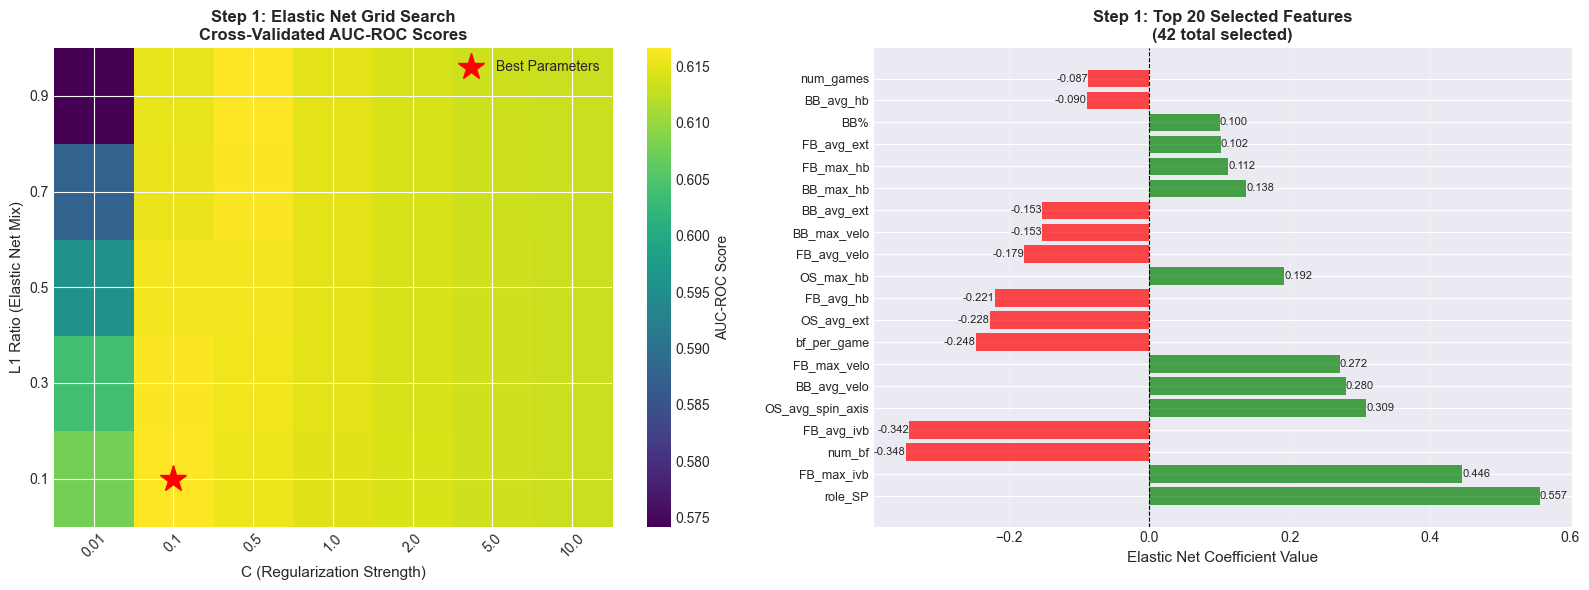

In [50]:
# Visualization: Elastic Net Grid Search Results and Feature Selection
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grid Search Results Heatmap
cv_results = grid_search.cv_results_
C_values = param_grid['C']
l1_ratios = param_grid['l1_ratio']
scores_matrix = np.zeros((len(l1_ratios), len(C_values)))

for i, l1_ratio in enumerate(l1_ratios):
    for j, C in enumerate(C_values):
        params = {'C': C, 'l1_ratio': l1_ratio}
        idx = [k for k, p in enumerate(cv_results['params']) if p == params][0]
        scores_matrix[i, j] = cv_results['mean_test_score'][idx]

im = axes[0].imshow(scores_matrix, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_xticks(range(len(C_values)))
axes[0].set_xticklabels(C_values, rotation=45)
axes[0].set_yticks(range(len(l1_ratios)))
axes[0].set_yticklabels(l1_ratios)
axes[0].set_xlabel('C (Regularization Strength)', fontsize=11)
axes[0].set_ylabel('L1 Ratio (Elastic Net Mix)', fontsize=11)
axes[0].set_title('Step 1: Elastic Net Grid Search\nCross-Validated AUC-ROC Scores', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[0], label='AUC-ROC Score')

# Mark best parameters
best_C_idx = C_values.index(grid_search.best_params_['C'])
best_l1_idx = l1_ratios.index(grid_search.best_params_['l1_ratio'])
axes[0].plot(best_C_idx, best_l1_idx, 'r*', markersize=20, label='Best Parameters')
axes[0].legend()

# Plot 2: Top Selected Features (show feature names)
top_n = min(20, len(selected_feature_names))
print(f"\nShowing top {top_n} selected features for visualization...")

# Get indices for top features based on Elastic Net coefficients
en_coefs = elastic_net_best.coef_[0][selected_feature_indices]
top_indices = np.argsort(np.abs(en_coefs))[-top_n:][::-1]
top_feature_names = [selected_feature_names[i] for i in top_indices]
top_coefs = en_coefs[top_indices]

colors = ['red' if x < 0 else 'green' for x in top_coefs]
bars = axes[1].barh(range(len(top_feature_names)), top_coefs, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_feature_names)))
axes[1].set_yticklabels(top_feature_names, fontsize=9)
axes[1].set_xlabel('Elastic Net Coefficient Value', fontsize=11)
axes[1].set_title(f'Step 1: Top {top_n} Selected Features\n({n_selected} total selected)', 
                 fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_coefs)):
    width = bar.get_width()
    label_x = width if width >= 0 else width
    axes[1].text(label_x, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right',
                va='center', fontsize=8)

plt.tight_layout()
plt.show()


---

## Model 3: Full GAM Model (Unmodifiable + Modifiable)

**Features:** All features from Model 1 + Model 2


In [51]:
# Model 3: Full GAM model (combine Model 1 and Model 2 features)
# Start with Model 1 features
X3_base = df_model[model1_features].copy()

# Encode categorical variable (birth_country) for GAM
birth_country_map_full = {country: idx for idx, country in enumerate(df_model['birth_country'].unique())}
X3_base['birth_country_encoded'] = X3_base['birth_country'].map(birth_country_map_full)

# Get continuous features from Model 1
X3_model1_continuous = X3_base[continuous_features + ['birth_country_encoded']].copy()

# Add Model 2 modifiable features (all of them)
X3_model2 = df_model[model2_features].copy()
# Handle categorical variable (pitcher_role) - encode for GAM
role_map_full = {role: idx for idx, role in enumerate(df_model['pitcher_role'].unique()) if pd.notna(role)}
X3_model2['pitcher_role_encoded'] = X3_model2['pitcher_role'].map(role_map_full).fillna(0)

# Get all numeric features from Model 2
X3_model2_numeric = X3_model2.drop(columns=['pitcher_role']).copy()
X3_model2_numeric['pitcher_role_encoded'] = X3_model2['pitcher_role_encoded']

# Combine all features
X3 = pd.concat([X3_model1_continuous, X3_model2_numeric], axis=1)

print(f"Total features in Model 3: {X3.shape[1]}")

# Use the same train/test split for all models
X3_train = X3.loc[train_idx]
X3_test = X3.loc[test_idx]
# y_train and y_test already defined

# Prepare feature matrix for GAM (all numeric)
X3_train_gam = X3_train.values
X3_test_gam = X3_test.values

# Build GAM terms: use smooth splines for all features
n_features = X3_train_gam.shape[1]
gam_term3 = s(0, n_splines=10)  # Start with first feature
for i in range(1, n_features):
    gam_term3 += s(i, n_splines=10)  # Smooth spline for all features

# Fit GAM
model3 = LogisticGAM(gam_term3)
model3.fit(X3_train_gam, y_train.values)

# Predictions
y3_pred_proba = model3.predict_proba(X3_test_gam)
y3_pred = (y3_pred_proba > 0.5).astype(int)

# Metrics
print("\n" + "=" * 60)
print("MODEL 3: Full GAM Model (Unmodifiable + Modifiable)")
print("=" * 60)
print(f"\nTotal features: {X3.shape[1]}")
print(f"\nAccuracy: {accuracy_score(y_test, y3_pred):.4f}")
print(f"Precision: {precision_score(y_test, y3_pred):.4f}")
print(f"Recall: {recall_score(y_test, y3_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y3_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y3_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y3_pred_proba):.4f}")

# Cross-validation
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx_cv, val_idx_cv) in enumerate(skf.split(X3_train_gam, y_train), 1):
    print(f"  CV Fold {fold}/5...", end='\r')
    X_cv_train = X3_train_gam[train_idx_cv]
    X_cv_val = X3_train_gam[val_idx_cv]
    y_cv_train = y_train.iloc[train_idx_cv].values
    y_cv_val = y_train.iloc[val_idx_cv].values
    
    gam_cv = LogisticGAM(gam_term3)
    gam_cv.fit(X_cv_train, y_cv_train)
    y_pred_cv = gam_cv.predict_proba(X_cv_val)
    cv_scores.append(roc_auc_score(y_cv_val, y_pred_cv))

print(f"\n5-Fold CV AUC-ROC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# Store Model 3 results
model3_results = {
    'model': model3,
    'feature_names': X3.columns.tolist(),
    'y_test': y_test,
    'y_pred': y3_pred,
    'y_pred_proba': y3_pred_proba,
    'accuracy': accuracy_score(y_test, y3_pred),
    'precision': precision_score(y_test, y3_pred),
    'recall': recall_score(y_test, y3_pred),
    'f1': f1_score(y_test, y3_pred),
    'auc_roc': roc_auc_score(y_test, y3_pred_proba),
    'log_loss': log_loss(y_test, y3_pred_proba),
    'X_train_gam': X3_train_gam,
    'X_test_gam': X3_test_gam
}


Total features in Model 3: 54

MODEL 3: Full GAM Model (Unmodifiable + Modifiable)

Total features: 54

Accuracy: 0.8143
Precision: 0.6098
Recall: 0.2874
F1-Score: 0.3906
AUC-ROC: 0.7579
Log Loss: 0.4373
  CV Fold 5/5...
5-Fold CV AUC-ROC: 0.7365 (+/- 0.0192)


---

## Model Comparison and Visualizations


In [52]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full'],
    'Accuracy': [model1_results['accuracy'], model2_results['accuracy'], model3_results['accuracy']],
    'Precision': [model1_results['precision'], model2_results['precision'], model3_results['precision']],
    'Recall': [model1_results['recall'], model2_results['recall'], model3_results['recall']],
    'F1-Score': [model1_results['f1'], model2_results['f1'], model3_results['f1']],
    'AUC-ROC': [model1_results['auc_roc'], model2_results['auc_roc'], model3_results['auc_roc']],
    'Log Loss': [model1_results['log_loss'], model2_results['log_loss'], model3_results['log_loss']]
})

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Log Loss
  Model 1: Baseline  0.815873   0.586826 0.375479  0.457944 0.684173  0.449132
Model 2: Modifiable  0.791270   0.468750 0.057471  0.102389 0.675783  0.480835
      Model 3: Full  0.814286   0.609756 0.287356  0.390625 0.757930  0.437323


In [53]:
# Display Model 3 statistics (model3_results already stored in Cell 13)
print("\n" + "=" * 80)
print("MODEL 3: GAM Model Information")
print("=" * 80)
print(f"\nTotal features: {X3.shape[1]}")
print(f"\nModel Statistics:")
print(f"  Deviance: {model3.statistics_['deviance']:.4f}")
try:
    pseudo_r2 = model3.statistics_['pseudo_r2']
    if isinstance(pseudo_r2, dict):
        r2_value = pseudo_r2.get('pseudo_r2', pseudo_r2.get('pseudo R2', 'N/A'))
    else:
        r2_value = pseudo_r2
    print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
except (KeyError, AttributeError, TypeError):
    try:
        r2_value = model3.statistics_['pseudo_r2']
        print(f"  Pseudo R-squared: {r2_value:.4f}" if isinstance(r2_value, (int, float)) else f"  Pseudo R-squared: {r2_value}")
    except:
        print(f"  Pseudo R-squared: N/A")
print("=" * 80)



MODEL 3: GAM Model Information

Total features: 54

Model Statistics:
  Deviance: 4103.3468
  Pseudo R-squared: N/A


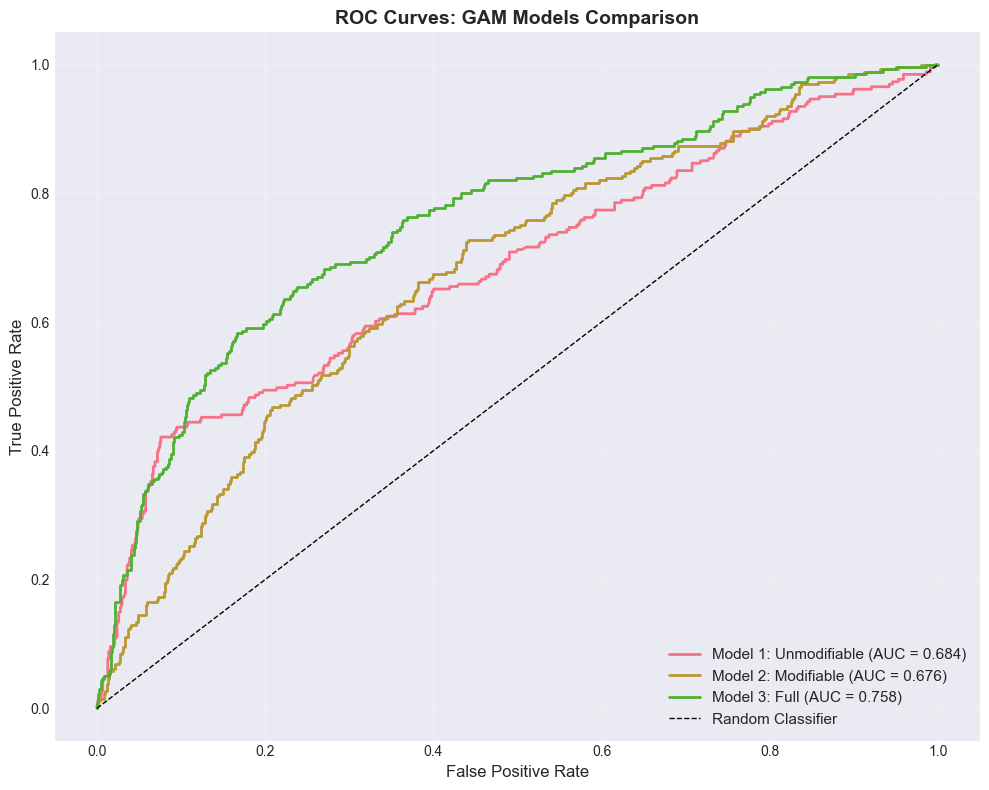

In [54]:
# Visualization 1: ROC Curves Comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC curves for all models
fpr1, tpr1, _ = roc_curve(model1_results['y_test'], model1_results['y_pred_proba'])
fpr2, tpr2, _ = roc_curve(model2_results['y_test'], model2_results['y_pred_proba'])
fpr3, tpr3, _ = roc_curve(model3_results['y_test'], model3_results['y_pred_proba'])

# Plot ROC curves
ax.plot(fpr1, tpr1, label=f"Model 1: Unmodifiable (AUC = {model1_results['auc_roc']:.3f})", linewidth=2)
ax.plot(fpr2, tpr2, label=f"Model 2: Modifiable (AUC = {model2_results['auc_roc']:.3f})", linewidth=2)
ax.plot(fpr3, tpr3, label=f"Model 3: Full (AUC = {model3_results['auc_roc']:.3f})", linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: GAM Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


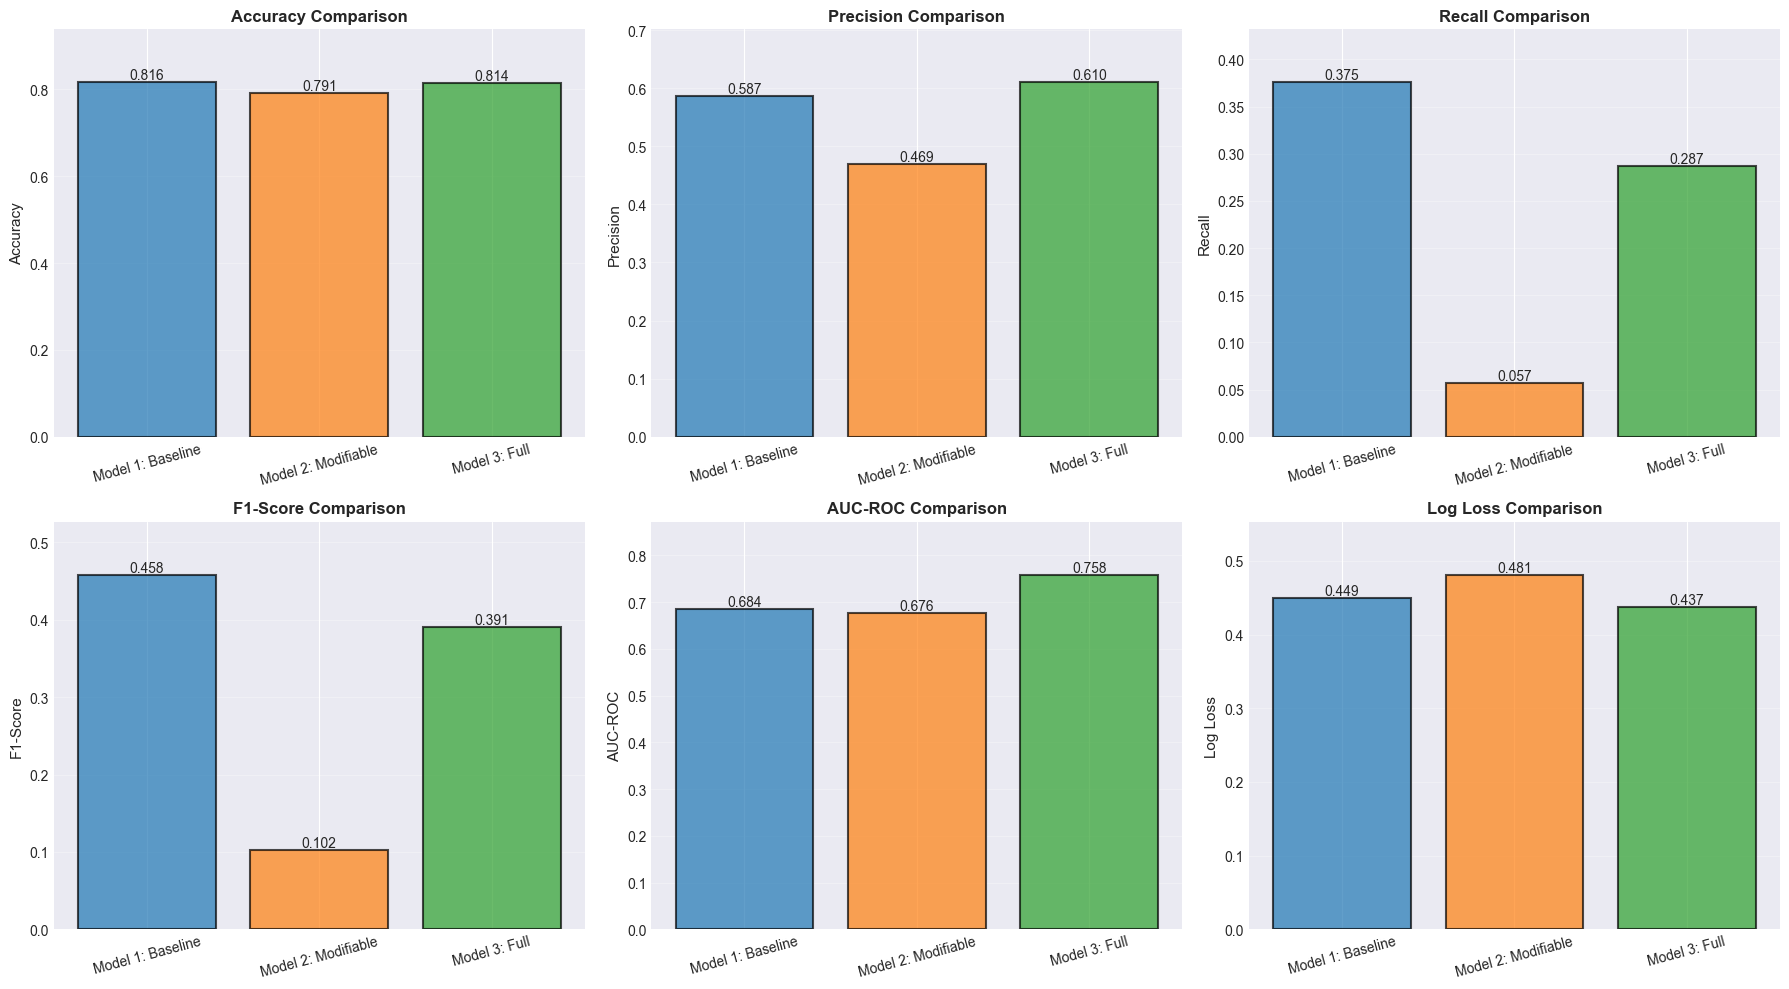

In [55]:
# Visualization 2: Performance Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, max(values) * 1.15])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


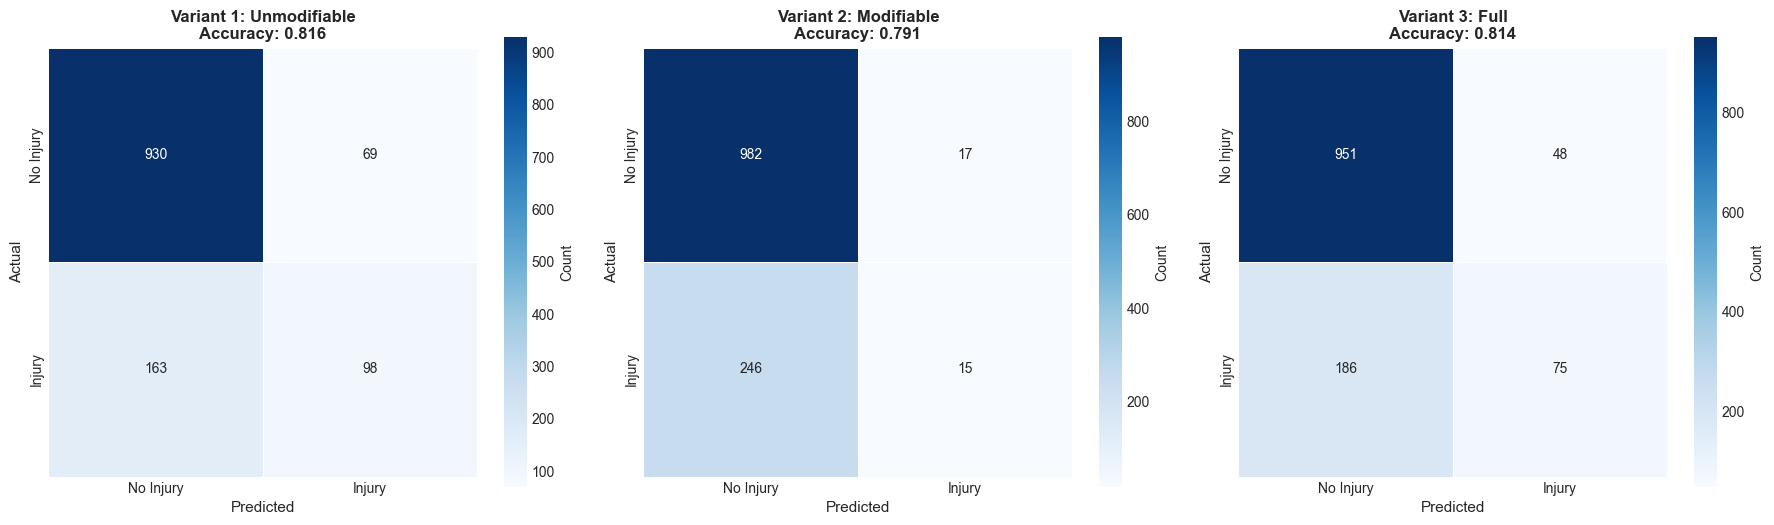

In [56]:
# Visualization 3: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Variant 1: Unmodifiable', 'Variant 2: Modifiable', 'Variant 3: Full']

for i, (results, name) in enumerate(zip(models_results, model_names)):
    cm = confusion_matrix(results['y_test'], results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar_kws={'label': 'Count'}, square=True, linewidths=0.5)
    axes[i].set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=11)
    axes[i].set_ylabel('Actual', fontsize=11)
    axes[i].set_xticklabels(['No Injury', 'Injury'])
    axes[i].set_yticklabels(['No Injury', 'Injury'])

plt.tight_layout()
plt.show()


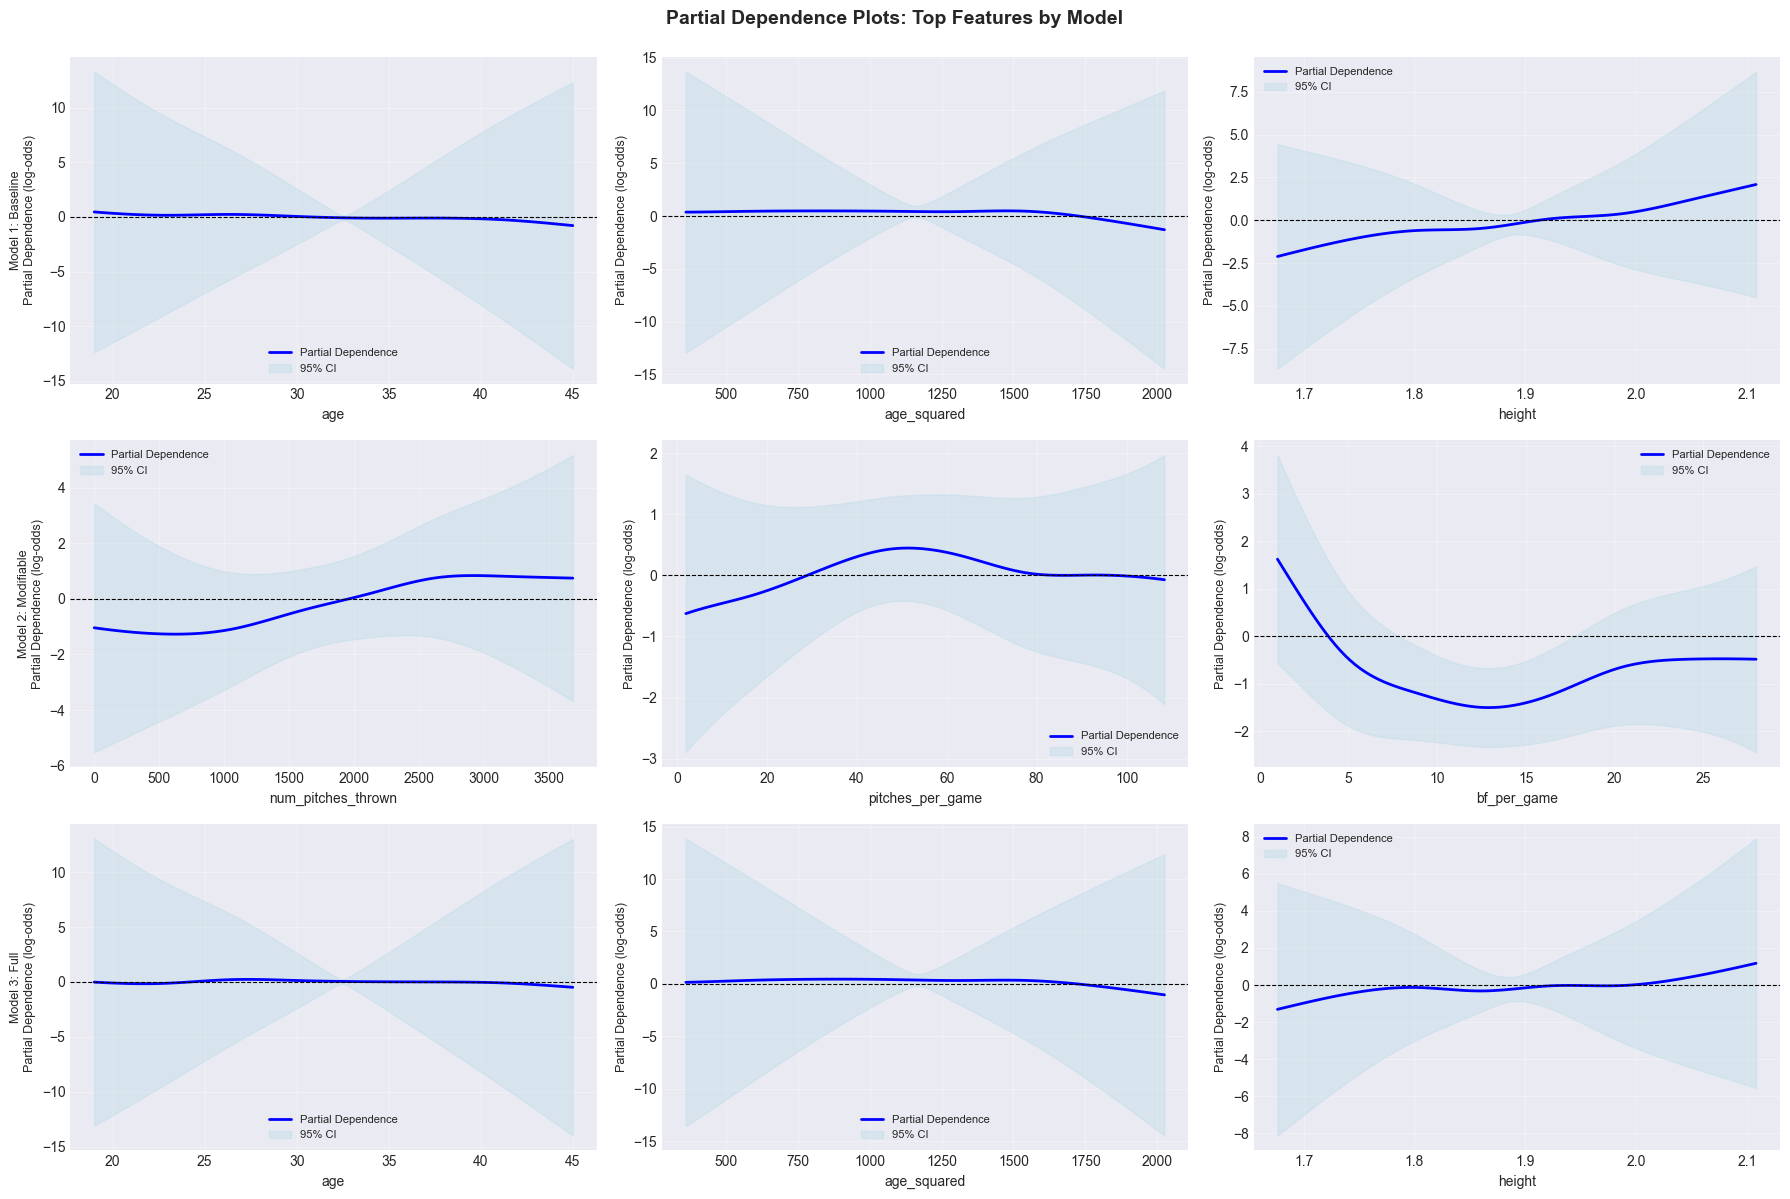

In [34]:
# Visualization 4: Partial Dependence Plots for Top Features (GAM-specific)
# For GAM models, we show partial dependence instead of coefficients
# Show top 3 features from each model
n_features_to_plot = 3
fig, axes = plt.subplots(3, n_features_to_plot, figsize=(18, 12))

models = [model1_results['model'], model2_results['model'], model3_results['model']]
model_names = ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full']
feature_names_list = [
    model1_results['feature_names'],
    model2_results['selected_feature_names'],
    model3_results['feature_names']
]

for model_idx, (gam_model, name, feat_names) in enumerate(zip(models, model_names, feature_names_list)):
    n_plot = min(n_features_to_plot, len(feat_names))
    
    for feat_plot_idx in range(n_features_to_plot):
        ax = axes[model_idx, feat_plot_idx]
        
        if feat_plot_idx < len(feat_names):
            feat_idx = feat_plot_idx
            feat_name = feat_names[feat_idx] if feat_idx < len(feat_names) else f'Feature {feat_idx}'
            
            try:
                # Generate partial dependence
                XX = gam_model.generate_X_grid(term=feat_idx, n=100)
                pdep, confi = gam_model.partial_dependence(term=feat_idx, X=XX, width=0.95)
                
                # Plot partial dependence with confidence interval
                ax.plot(XX[:, feat_idx], pdep, linewidth=2, label='Partial Dependence', color='blue')
                ax.fill_between(XX[:, feat_idx], confi[:, 0], confi[:, 1], alpha=0.3, label='95% CI', color='lightblue')
                ax.set_xlabel(feat_name, fontsize=10)
                ax.set_ylabel('Partial Dependence (log-odds)', fontsize=9)
                if feat_plot_idx == 0:
                    ax.set_ylabel(f'{name}\nPartial Dependence (log-odds)', fontsize=9)
                ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
                ax.grid(alpha=0.3)
                ax.legend(fontsize=8)
            except Exception as e:
                ax.text(0.5, 0.5, f'Error plotting\n{feat_name}', ha='center', va='center', transform=ax.transAxes, fontsize=9)
                ax.set_title(feat_name, fontsize=10)
        else:
            ax.axis('off')

plt.suptitle('Partial Dependence Plots: Top Features by Model', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


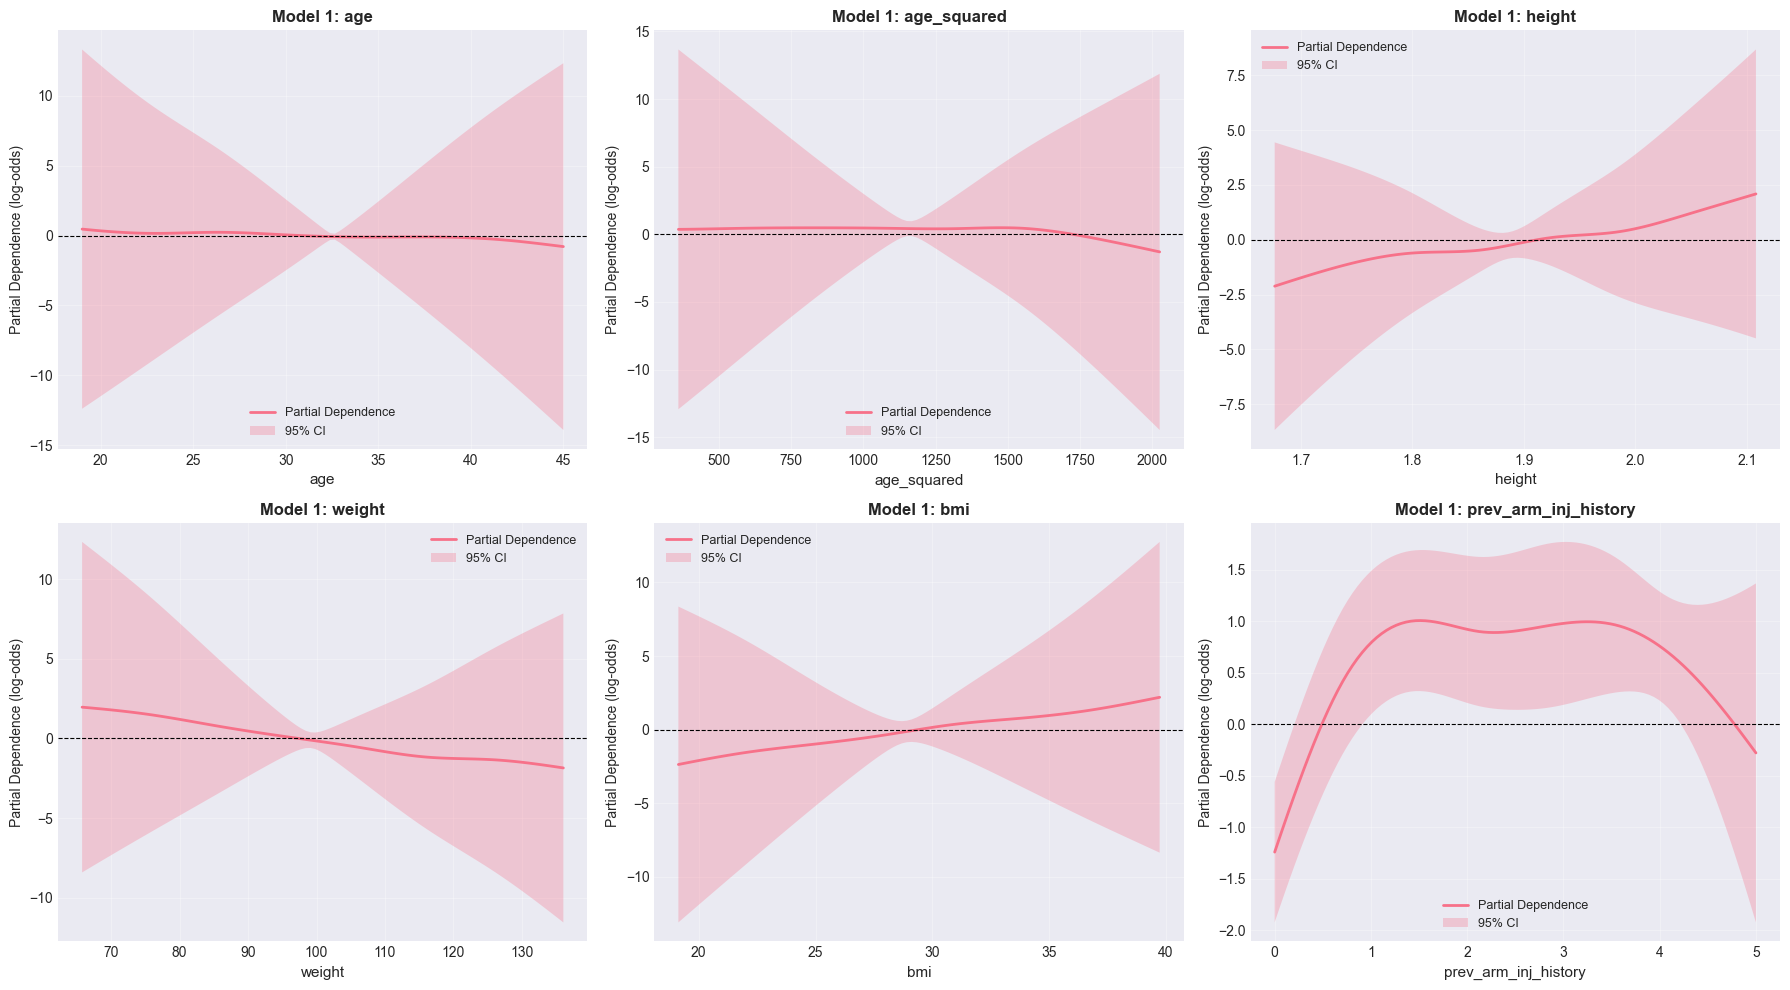

In [35]:
# Visualization 5: Individual Partial Dependence Plots for Model 1 (Baseline)
# Show detailed partial dependence for each continuous feature in Model 1
n_continuous = len(continuous_features)
n_cols = 3
n_rows = (n_continuous + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if n_continuous > 1 else [axes]

for i, feat_name in enumerate(continuous_features):
    ax = axes[i]
    feat_idx = continuous_features.index(feat_name)
    
    try:
        # Generate partial dependence
        XX = model1.generate_X_grid(term=feat_idx, n=100)
        pdep, confi = model1.partial_dependence(term=feat_idx, X=XX, width=0.95)
        
        # Plot partial dependence with confidence interval
        ax.plot(XX[:, feat_idx], pdep, linewidth=2, label='Partial Dependence')
        ax.fill_between(XX[:, feat_idx], confi[:, 0], confi[:, 1], alpha=0.3, label='95% CI')
        ax.set_xlabel(feat_name, fontsize=11)
        ax.set_ylabel('Partial Dependence (log-odds)', fontsize=10)
        ax.set_title(f'Model 1: {feat_name}', fontsize=12, fontweight='bold')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=9)
    except Exception as e:
        ax.text(0.5, 0.5, f'Error plotting {feat_name}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Model 1: {feat_name}', fontsize=12, fontweight='bold')

# Hide unused subplots
for i in range(n_continuous, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


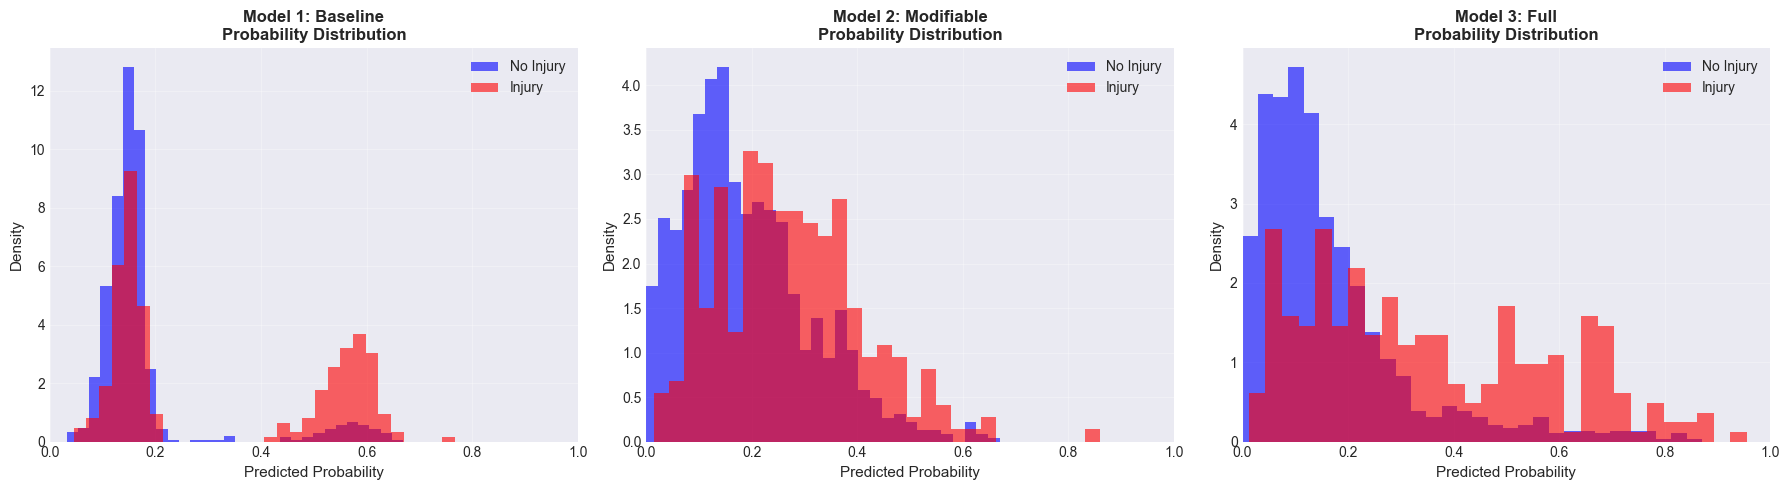

In [57]:
# Visualization 6: Prediction Probability Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pred_probas = [
    (model1_results['y_pred_proba'], model1_results['y_test'], 'Model 1: Baseline'),
    (model2_results['y_pred_proba'], model2_results['y_test'], 'Model 2: Modifiable'),
    (model3_results['y_pred_proba'], model3_results['y_test'], 'Model 3: Full')
]

for i, (proba, true_labels, name) in enumerate(pred_probas):
    ax = axes[i]
    
    # Separate predictions by actual class
    no_injury_proba = proba[true_labels == 0]
    injury_proba = proba[true_labels == 1]
    
    ax.hist(no_injury_proba, bins=30, alpha=0.6, label='No Injury', color='blue', density=True)
    ax.hist(injury_proba, bins=30, alpha=0.6, label='Injury', color='red', density=True)
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name}\nProbability Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])

plt.tight_layout()
plt.show()


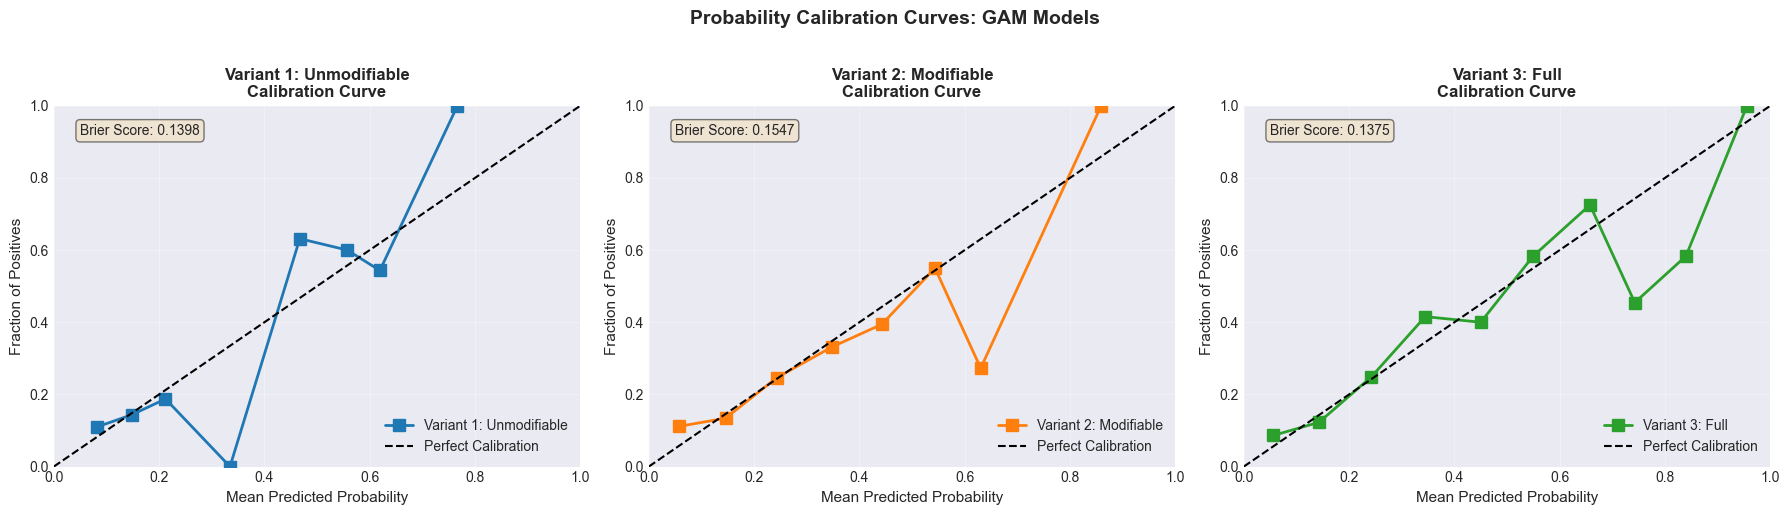

In [59]:
# Visualization 7: Probability Calibration Curves
# Calibration curves show how well the predicted probabilities match the actual probabilities
# A well-calibrated model should have predicted probabilities that match observed frequencies

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Variant 1: Unmodifiable', 'Variant 2: Modifiable', 'Variant 3: Full']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (results, name, color) in enumerate(zip(models_results, model_names, colors)):
    ax = axes[i]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        results['y_test'], 
        results['y_pred_proba'], 
        n_bins=10,
        strategy='uniform'
    )
    
    # Plot calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', 
           label=f'{name}', color=color, linewidth=2, markersize=8)
    
    # Plot perfect calibration line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1.5)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title(f'{name}\nCalibration Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Calculate Brier score (calibration metric)
    from sklearn.metrics import brier_score_loss
    brier_score = brier_score_loss(results['y_test'], results['y_pred_proba'])
    ax.text(0.05, 0.95, f'Brier Score: {brier_score:.4f}', 
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Probability Calibration Curves: GAM Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Visualization 8: Combined Calibration Curve Comparison
# Show all three models on the same plot for easier comparison

fig, ax = plt.subplots(figsize=(10, 8))

models_results = [model1_results, model2_results, model3_results]
model_names = ['Model 1: Baseline', 'Model 2: Modifiable', 'Model 3: Full']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for results, name, color, marker in zip(models_results, model_names, colors, markers):
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        results['y_test'], 
        results['y_pred_proba'], 
        n_bins=10,
        strategy='uniform'
    )
    
    # Plot calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, marker=marker, 
           label=f'{name}', color=color, linewidth=2, markersize=8, alpha=0.8)

# Plot perfect calibration line (diagonal)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Probability Calibration Curves: GAM Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Add Brier scores in legend or as text
from sklearn.metrics import brier_score_loss
brier_scores = [brier_score_loss(r['y_test'], r['y_pred_proba']) for r in models_results]
brier_text = '\n'.join([f'{name}: {score:.4f}' for name, score in zip(model_names, brier_scores)])
ax.text(0.98, 0.02, f'Brier Scores:\n{brier_text}', 
       transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
       horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()
